In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

In [36]:
quotes = pd.read_table(r'C:\Users\mikha\Desktop\Учёба DAS\ML\Занятие 2\GAZP_210801_220806.txt', header = 0, sep = ',', parse_dates = ['<DATE>'])

In [37]:
quotes

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,2021-08-02,0,287.88,289.48,285.21,286.75,38297270
1,GAZP,D,2021-08-03,0,286.77,288.05,284.34,287.09,27065240
2,GAZP,D,2021-08-04,0,287.89,288.80,286.00,287.94,23599750
3,GAZP,D,2021-08-05,0,287.31,288.28,285.16,285.95,47254880
4,GAZP,D,2021-08-06,0,285.26,285.72,277.87,282.27,90600850
...,...,...,...,...,...,...,...,...,...
233,GAZP,D,2022-08-01,0,194.50,194.69,192.00,192.00,13034930
234,GAZP,D,2022-08-02,0,191.56,191.68,186.80,187.16,24267570
235,GAZP,D,2022-08-03,0,187.59,188.97,186.31,187.04,12005960
236,GAZP,D,2022-08-04,0,187.04,187.22,184.30,184.90,13313950


In [38]:
# Зададим индекс
quotes.set_index('<DATE>', inplace = True)
quotes.sort_index(inplace = True)
print('Монотонность - ',quotes.index.is_monotonic)

Монотонность -  True


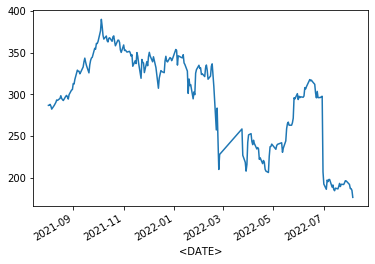

In [39]:
quotes['<CLOSE>'].plot()

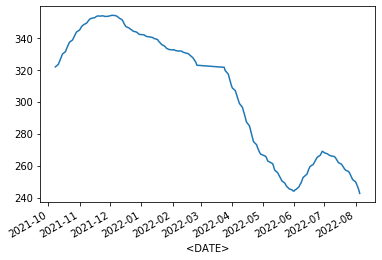

In [40]:
quotes['<CLOSE>'].rolling(50).mean().plot()

In [41]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['<CLOSE>'].shift(lag)

    data['price_mean'] = data['<CLOSE>'].shift().rolling(rolling_mean_size).mean().copy()

In [42]:
make_features(quotes, 10, 7)

In [43]:
quotes.dropna(inplace = True)

In [44]:
quotes.columns

Index(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>',
       '<VOL>', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'price_mean'],
      dtype='object')

In [45]:
# нужно выбрать отдельные факторы, боимся мультиколлинеарности
features = quotes[['year','month','day','price_mean']]

In [46]:
target = quotes['<CLOSE>']
X_train,X_test,y_train, y_test = train_test_split(features,target, shuffle=False, test_size=0.25)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (171, 4)
X_test (57, 4)


In [47]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
y_predicted_lr = model_lr.predict(X_test)
print("RMSE тестовой выборки LinearRegression: ",np.sqrt(mean_squared_error(y_test, y_predicted_lr)))

RMSE тестовой выборки LinearRegression:  26.675612574153043


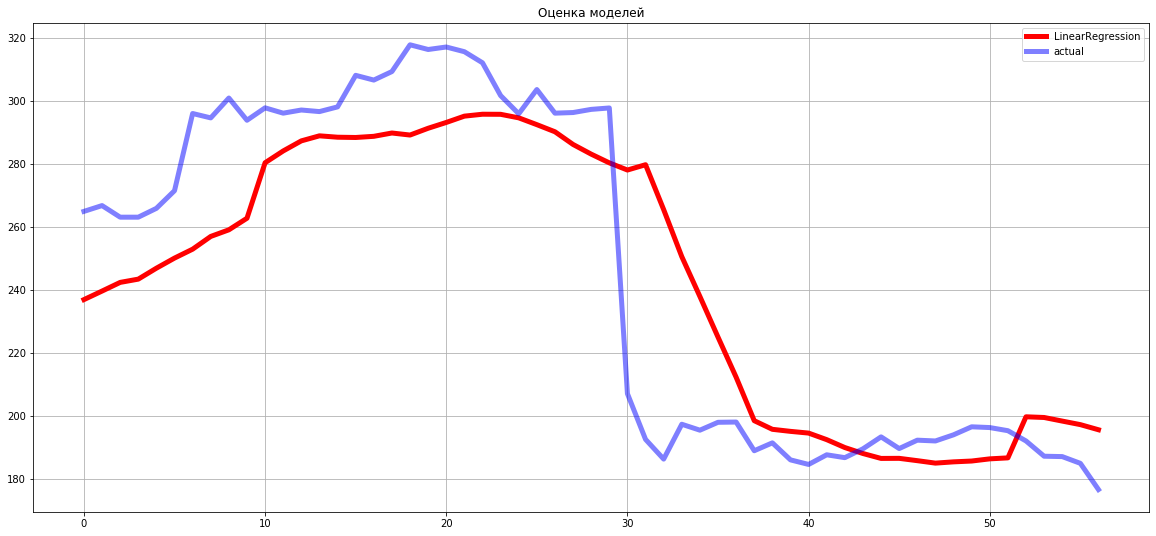

In [49]:
plt.figure(figsize=(20, 9))
plt.plot(y_predicted_lr, "r",linewidth=5, label="LinearRegression")
plt.plot(y_test.values,'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True)

In [51]:
## Пророчим!

m = Prophet()
quotes = pd.read_table(r'C:\Users\mikha\Desktop\Учёба DAS\ML\Занятие 2\GAZP_210801_220806.txt', header = 0, sep = ',', parse_dates = ['<DATE>'])
quotes.set_index('<DATE>', inplace = True)
quotes.sort_index(inplace = True)
quotes_prophet = quotes[['<CLOSE>']].reset_index()
quotes_prophet.columns = ['ds','y']
m.fit(quotes_prophet)


15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing
15:55:03 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing
15:55:05 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization: 